In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Flatten,Attention, Concatenate, Input ,Reshape
from tensorflow.keras.optimizers import Adam,RMSprop
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error,precision_score
import numpy as np
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K



In [2]:
file_path = r"../data_2/dataset.csv"
df = pd.read_csv(file_path)

In [3]:
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9
0,0.184,106401.5980,103157.1785,1293.4311,592,1150,0.7705,0.2313,0.018043
1,0.184,106399.9771,103155.4379,1293.4311,592,1150,0.7705,0.2313,0.018043
2,0.184,106399.9771,103155.4379,1293.4311,592,1150,0.7705,0.2313,0.000000
3,0.184,106400.7710,103156.2771,1293.4311,592,1150,0.7705,0.2313,0.008414
4,0.184,106402.8029,103158.1105,1293.4311,592,1150,0.7705,0.2313,0.008564


In [4]:
df.drop(['Feature9'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Feature1  300 non-null    float64
 1   Feature2  300 non-null    float64
 2   Feature3  300 non-null    float64
 3   Feature4  300 non-null    float64
 4   Feature5  300 non-null    int64  
 5   Feature6  300 non-null    int64  
 6   Feature7  300 non-null    float64
 7   Feature8  300 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 18.9 KB


In [5]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the data
data = scaler.fit_transform(df)

In [6]:
time_steps = 8  # 8 rows (1 year)
future_steps = 40  # Predicting 40 rows (5 years)
X, Y = [], []

# Stop at a safe index to prevent out-of-bounds errors
for i in range(len(data) - time_steps - future_steps + 1):
    X.append(data[i:i + time_steps])          # Past 8 rows
    Y.append(data[i + time_steps: i + time_steps + future_steps])  # Next 40 rows

X, Y = np.array(X), np.array(Y)  

print(f" Dataset shape: X={X.shape}, Y={Y.shape}")  # (252, 8, 8) and (252, 40, 8)

 Dataset shape: X=(253, 8, 8), Y=(253, 40, 8)


In [7]:
X, Y = np.array(X), np.array(Y)
print("Shape of X:", X.shape)  # (samples, time_steps, features)
print("Shape of Y:", Y.shape)  # (samples, features)

Shape of X: (253, 8, 8)
Shape of Y: (253, 40, 8)


Formulate the Model 

In [8]:
input_layer = Input(shape=(X.shape[1], X.shape[2]))  # (8, 8)

# LSTM layer
lstm_out = LSTM(64, return_sequences=True)(input_layer)
lstm_out = Dropout(0.2)(lstm_out)

# GRU layer
gru_out = GRU(64, return_sequences=True)(lstm_out)
gru_out = Dropout(0.2)(gru_out)

# Attention layer applied after concatenation
concat_out = Concatenate()([lstm_out, gru_out])
attention_out = Attention()([concat_out, concat_out])

# Flatten the concatenated output
flatten_out = Flatten()(attention_out)

# Dense layers
dense_out = Dense(128, activation='relu')(flatten_out)
dense_out = Dropout(0.2)(dense_out)
output_layer = Dense(40 * 8, activation='linear')(dense_out)  # Predicting 40 rows, 8 columns

# Reshape to (40, 8)
output_layer = Reshape((40, 8))(output_layer)

In [9]:
# Build the model using the Functional API

# Custom RMSE metric
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Custom MAPE metric
def mape(y_true, y_pred):
    return K.mean(K.abs((y_true - y_pred) / K.clip(K.abs(y_true), K.epsilon(), None))) * 100

# Custom accuracy metric
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

# Custom precision metric
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


In [10]:
from tensorflow.keras.optimizers import Adamax
optimizer = Adamax(learning_rate=0.002)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error', rmse, mape, accuracy, precision])

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8, 8)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 8, 64)     │     18,688 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8, 64)     │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 8, 64)     │     24,960 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 64)     │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 128)    │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 8, 128)    │          0 │ concatenate[0][0… │
│ (Attention)         │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1024)      │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    131,200 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 320)       │     41,280 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 40, 8)     │          0 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 216,128 (844.25 KB)

 Trainable params: 216,128 (844.25 KB)

 Non-trainable params: 0 (0.00 B)

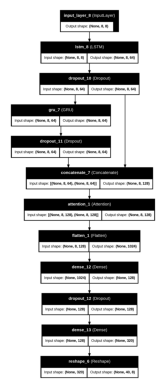

In [11]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

In [12]:
# Train the model
history = model.fit(X, Y, epochs=150, batch_size=20, callbacks=[early_stopping])

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.0000e+00 - loss: 0.8346 - mape: 127.3479 - mean_absolute_error: 0.7304 - precision: 4.3659 - rmse: 0.9104
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.6331 - mape: 142.3012 - mean_absolute_error: 0.6238 - precision: 3.1579 - rmse: 0.7937
Epoch 3/150


c:\Users\Roumo\Desktop\WaterLevel\.venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,mape,mean_absolute_error,precision,rmse
  current = self.get_monitor_value(logs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.5128 - mape: 141.9224 - mean_absolute_error: 0.5535 - precision: 2.2317 - rmse: 0.7135
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 0.5130 - mape: 139.1292 - mean_absolute_error: 0.5579 - precision: 3.5354 - rmse: 0.7141
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.4621 - mape: 146.0169 - mean_absolute_error: 0.5263 - precision: 2.2273 - rmse: 0.6771
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.4281 - mape: 148.0644 - mean_absolute_error: 0.5074 - precision: 2.7409 - rmse: 0.6527
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 0.4197 - mape: 166.2463 - mean_absolute_error: 0.5041 - precision: 1.9260 - rmse: 0.6462
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.3874 - mape: 161.4225 - mean_absolute_error: 0.4829 - precision: 1.822

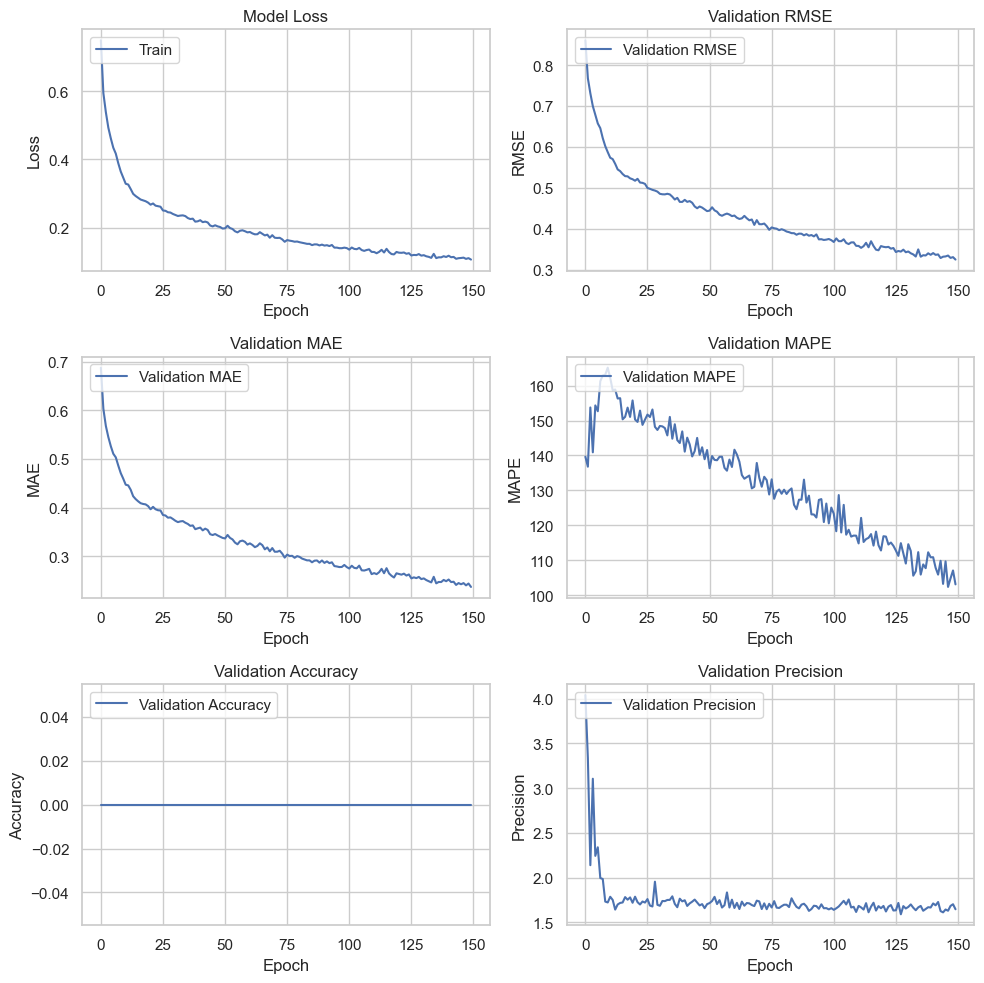

In [13]:
# Extract the metrics from the history
train_loss = history.history['loss']
val_rmse = history.history['rmse']
val_mae = history.history['mean_absolute_error']
val_mape = history.history['mape']
val_accuracy = history.history['accuracy']
val_precision = history.history['precision']

# Plot the performance metrics using seaborn
sns.set(style="whitegrid")

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Plot training & validation loss values
sns.lineplot(x=range(len(train_loss)), y=train_loss, ax=axs[0, 0], label='Train')
axs[0, 0].set_title('Model Loss')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].legend(loc='upper left')

# Plot RMSE values
sns.lineplot(x=range(len(val_rmse)), y=val_rmse, ax=axs[0, 1], label='Validation RMSE')
axs[0, 1].set_title('Validation RMSE')
axs[0, 1].set_ylabel('RMSE')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].legend(loc='upper left')

# Plot MAE values
sns.lineplot(x=range(len(val_mae)), y=val_mae, ax=axs[1, 0], label='Validation MAE')
axs[1, 0].set_title('Validation MAE')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].legend(loc='upper left')

# Plot MAPE values
sns.lineplot(x=range(len(val_mape)), y=val_mape, ax=axs[1, 1], label='Validation MAPE')
axs[1, 1].set_title('Validation MAPE')
axs[1, 1].set_ylabel('MAPE')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].legend(loc='upper left')

# Plot Accuracy values
sns.lineplot(x=range(len(val_accuracy)), y=val_accuracy, ax=axs[2, 0], label='Validation Accuracy')
axs[2, 0].set_title('Validation Accuracy')
axs[2, 0].set_ylabel('Accuracy')
axs[2, 0].set_xlabel('Epoch')
axs[2, 0].legend(loc='upper left')

# Plot Precision values
sns.lineplot(x=range(len(val_precision)), y=val_precision, ax=axs[2, 1], label='Validation Precision')
axs[2, 1].set_title('Validation Precision')
axs[2, 1].set_ylabel('Precision')
axs[2, 1].set_xlabel('Epoch')
axs[2, 1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [14]:
# Print the metrics
print("Training Loss: ", train_loss[-1])
print("Validation RMSE: ", val_rmse[-1])
print("Validation MAE: ", val_mae[-1])
print("Validation MAPE: ", val_mape[-1])
print("Validation Precision: ", val_precision[-1])


Training Loss:  0.10589686036109924
Validation RMSE:  0.32449987530708313
Validation MAE:  0.23719041049480438
Validation MAPE:  103.13961791992188
Validation Precision:  1.6458969116210938


In [15]:
# Prepare the input with the last 8 rows
future_input = data[-time_steps:].reshape(1, time_steps, df.shape[1])

# Directly predict the next 40 rows
future_predictions = model.predict(future_input)  # Shape: (1, 40, 8)

# Remove batch dimension
future_predictions = future_predictions[0]  # Shape: (40, 8)

# Inverse transform back to original scale
future_predictions = scaler.inverse_transform(future_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


In [18]:
future_years = np.arange(2022, 2027).repeat(8)
future_df = pd.DataFrame(future_predictions, columns=df.columns)
future_df["Year"] = future_years
future_df.to_csv(r"../data_3/LSTM.csv", index=False)

In [17]:
model.save(r'Models/Deploy/LSTM.h5')